In [1]:
import numpy as np
import pandas as pd
import s3fs
import boto3
import snowflake.connector
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
from sf import sf_connection
pd.options.display.float_format = '{:20,.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None

/usr/local/lib64/python3.7/site-packages/snowflake/connector/options.py:78: UserWarning: You have an incompatible version of 'pyarrow' installed (3.0.0), please install a version that adheres to: 'pyarrow<0.18.0,>=0.17.0; extra == "pandas"'
  warn_incompatible_dep('pyarrow', _installed_pyarrow_version.version, _expected_pyarrow_version)


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display
%matplotlib inline

In [3]:
conn = sf_connection()

In [4]:
diy_discount_reduced_query = f"""    
   
     select
        LOYALTY_NUMBER,
        count(distinct TRANSACTION_IDENTIFIER) as TX_COUNT,
        sum(USED_SP_DISCOUNT) as SP_COUNT,
        sum(USED_AF_DISCOUNT) as AF_COUNT,
        sum(USED_ANY_DISCOUNT) as DISCOUNT_COUNT,
        sum(COUPON_DISCOUNT_PRORATION_AMT*USED_SP_DISCOUNT) as COUPON_DISCOUNT_PRORATION_AMT, 
        sum(POS_SALES_DISCOUNT_AMOUNT*USED_AF_DISCOUNT) as POS_SALES_DISCOUNT_AMOUNT
        
        
        
    from
        
    
    (select
        TRANSACTION_IDENTIFIER,
        max(MAX_LOYALTY_NUMBER) as LOYALTY_NUMBER,
        max(COUPON_CEV_ID) as COUPON_CEV_ID,
        sum(COUPON_DISCOUNT_PRORATION_AMT) as COUPON_DISCOUNT_PRORATION_AMT,
        sum(POS_SALES_DISCOUNT_AMOUNT) as POS_SALES_DISCOUNT_AMOUNT,
        max(case when COUPON_DISCOUNT_PRORATION_AMT > 0 and COUPON_TYPE is null then 1 else 0 end) as USED_SP_DISCOUNT,
        max(case when POS_SALES_DISCOUNT_AMOUNT > 0 then 1 else 0 end) as USED_AF_DISCOUNT,
        case when (USED_SP_DISCOUNT+USED_AF_DISCOUNT)>0 then 1 else 0 end as USED_ANY_DISCOUNT        

        
        
    from
    
    (select distinct
        INDV_ID,
        TRANSACTION_IDENTIFIER,
        COUPON_CEV_ID,
        LOYALTY_NUMBER,
        COUPON_DISCOUNT_PRORATION_AMT,
        POS_SALES_DISCOUNT_AMOUNT,
        max(LOYALTY_NUMBER) over (partition by INDV_ID) as MAX_LOYALTY_NUMBER,
        COUPON_TYPE
    from PEDW.SALES_PROTECTED.FACT_ITEM_TRANSACTION_SALES_V as fits
    
    inner join
    (select distinct
        TRANSACTION_ID,
        SEQ_NUMBER, INDV_ID,
        TRAN_DATE 
    from PEDW.SALES_PROTECTED.FACT_ITEM_TRANSACTION_SALES_EXTN_V
    where TRAN_DATE >= '2017-10-01' and TRAN_DATE <= '2019-09-30'
    ) as fits_extn
    on fits.TRANSACTION_IDENTIFIER=fits_extn.TRANSACTION_ID and fits.SEQ_NUMBER=fits_extn.SEQ_NUMBER
    
    left join
    (select distinct reward_type, case when reward_type in ('Save5Off5','Save10Off10','Save15Off15','Save20Off20') then 'SP 2.0'
          when reward_type in ('Save10Off40', 'Save20Off50', 'Save40Off100', 'Save5Off20') then 'SP 1.0'
          end as coupon_type,
          b.*
        from CUSTOMER_PROTECTED.SP_REWARD_HISTORY_V as a
        inner join CUSTOMER_PROTECTED.DIM_CAMPAIGN_EVENT_V as b
        on a.coupon_code = b.campaign_event_code
        where full_date >= '2017-12-01' and (reward_type in ('Save10Off40', 'Save20Off50', 'Save40Off100', 'Save5Off20')
                                           or reward_type in ('Save10Off10', 'Save15Off15', 'Save20Off20', 'Save5Off5'))
        ) as rewards
        on fits.coupon_cev_id = rewards.campaign_event_id
    where fits.TRAN_DATE >= '2017-10-01' and fits.TRAN_DATE <= '2019-09-30' and SALES_CHANNEL_IDENTIFIER in (1,3)
    and TRANSACTION_CLASS_FLAG = 'S' and TRAN_COUNT_IND = 'Y' and INDV_ID is not null)
    where MAX_LOYALTY_NUMBER > 0 
    
    group by TRANSACTION_IDENTIFIER order by TRANSACTION_IDENTIFIER)
    
    group by LOYALTY_NUMBER order by LOYALTY_NUMBER
    
    
    

 """

### corrected

In [5]:
test_results = pd.read_sql(diy_discount_reduced_query, conn)

### Changed dates and filter by Epsilon data

In [6]:
epsilon_features = pd.read_csv('s3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/epsilon/epsilon_features.csv', header=0)

In [7]:
len(test_results), len(epsilon_features)

(16133071, 3206661)

In [8]:
len(test_results.drop_duplicates()), len(epsilon_features.drop_duplicates())

(16133071, 3089891)

In [9]:
epsilon_features.drop_duplicates(inplace=True)

In [10]:
test_results.dtypes

LOYALTY_NUMBER                     int64
TX_COUNT                           int64
SP_COUNT                           int64
AF_COUNT                           int64
DISCOUNT_COUNT                     int64
COUPON_DISCOUNT_PRORATION_AMT    float64
POS_SALES_DISCOUNT_AMOUNT        float64
dtype: object

In [11]:
epsilon_features.dtypes

speed_id         int64
mean_wallet    float64
dtype: object

In [12]:
epsilon_features.rename(columns={'speed_id': 'LOYALTY_NUMBER'}, inplace=True)

In [13]:
test_results = pd.merge(test_results, epsilon_features, how='inner', on='LOYALTY_NUMBER')

In [14]:
len(test_results)

2188001

### End Filter

In [15]:
test_results.mean()

LOYALTY_NUMBER                  7,770,106,981,871,847.00
TX_COUNT                                            8.03
SP_COUNT                                            0.11
AF_COUNT                                            2.21
DISCOUNT_COUNT                                      2.28
COUPON_DISCOUNT_PRORATION_AMT                       1.23
POS_SALES_DISCOUNT_AMOUNT                          29.50
mean_wallet                                         0.35
dtype: float64

In [16]:
test_results.sum()

LOYALTY_NUMBER                  -6,896,189,517,635,955,712.00
TX_COUNT                                        17,575,335.00
SP_COUNT                                           235,014.00
AF_COUNT                                         4,846,416.00
DISCOUNT_COUNT                                   4,994,161.00
COUPON_DISCOUNT_PRORATION_AMT                    2,681,482.64
POS_SALES_DISCOUNT_AMOUNT                       64,536,211.75
mean_wallet                                        776,363.06
dtype: float64

In [17]:
len(test_results)

2188001

In [18]:
2272602 - 1129633

1142969

In [19]:
test_results['DISCOUNT_FRACTION'] = test_results['DISCOUNT_COUNT']/test_results['TX_COUNT']

In [20]:
len(test_results[test_results.DISCOUNT_FRACTION > 0])

1075641

In [21]:
1142969/2272602

0.5029340817265847

In [22]:
multiple = test_results[test_results.TX_COUNT > 1]

In [23]:
len(multiple)

1741338

### One and done

In [24]:
2272602 - 1824043

448559

In [25]:
len(multiple[multiple.DISCOUNT_FRACTION > 0])

919412

In [26]:
986019/1824043

0.540567848455327

In [27]:
multiple = test_results[test_results.TX_COUNT > 2]

In [28]:
len(multiple)

1428505

In [29]:
len(multiple[multiple.DISCOUNT_FRACTION > 0])

800035

In [30]:
865376/1508706

0.573588227262303

array([[<AxesSubplot:title={'center':'DISCOUNT_FRACTION'}>]], dtype=object)

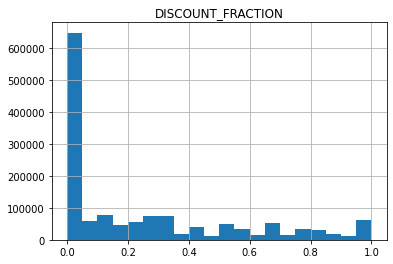

In [31]:
multiple.hist(column='DISCOUNT_FRACTION', bins=20, density=False)

In [32]:
pd.cut(multiple['DISCOUNT_FRACTION'], 20).value_counts()

(-0.001, 0.05]    650811
(0.15, 0.2]        80765
(0.3, 0.35]        75189
(0.05, 0.1]        68697
(0.2, 0.25]        66992
(0.1, 0.15]        66760
(0.95, 1.0]        61788
(0.65, 0.7]        51611
(0.45, 0.5]        51049
(0.35, 0.4]        38093
(0.7, 0.75]        37225
(0.55, 0.6]        33535
(0.25, 0.3]        28039
(0.75, 0.8]        24852
(0.4, 0.45]        21192
(0.85, 0.9]        19986
(0.8, 0.85]        17802
(0.6, 0.65]        15399
(0.5, 0.55]         9728
(0.9, 0.95]         8992
Name: DISCOUNT_FRACTION, dtype: int64

In [33]:
test_results.mean()

LOYALTY_NUMBER                  7,770,106,981,871,847.00
TX_COUNT                                            8.03
SP_COUNT                                            0.11
AF_COUNT                                            2.21
DISCOUNT_COUNT                                      2.28
COUPON_DISCOUNT_PRORATION_AMT                       1.23
POS_SALES_DISCOUNT_AMOUNT                          29.50
mean_wallet                                         0.35
DISCOUNT_FRACTION                                   0.27
dtype: float64

In [34]:
test_results.head()

LOYALTY_NUMBER  TX_COUNT  SP_COUNT  AF_COUNT  DISCOUNT_COUNT  \
0  7770000000001003         9         0         0               0   
1  7770000000001011        13         0         0               0   
2  7770000000001025        12         2        12              12   
3  7770000000001170         1         0         0               0   
4  7770000000001202         6         0         0               0   

   COUPON_DISCOUNT_PRORATION_AMT  POS_SALES_DISCOUNT_AMOUNT  \
0                           0.00                       0.00   
1                           0.00                       0.00   
2                          10.00                     254.47   
3                           0.00                       0.00   
4                           0.00                       0.00   

           mean_wallet    DISCOUNT_FRACTION  
0                 0.60                 0.00  
1                 0.60                 0.00  
2                 0.33                 1.00  
3                 0.00                 0.00  
4                 0.50                 0.00

In [35]:
test_results.loc[test_results['DISCOUNT_FRACTION'] > 0, 'zero'] = 0
test_results.loc[test_results['DISCOUNT_FRACTION'] > 0.25, 'quarter'] = 0
test_results.loc[test_results['DISCOUNT_FRACTION'] > 0.5, 'half'] = 0
test_results.loc[test_results['DISCOUNT_FRACTION'] > 0.75, '3quarter'] = 0

In [36]:
test_results.isnull().sum()

LOYALTY_NUMBER                         0
TX_COUNT                               0
SP_COUNT                               0
AF_COUNT                               0
DISCOUNT_COUNT                         0
COUPON_DISCOUNT_PRORATION_AMT          0
POS_SALES_DISCOUNT_AMOUNT              0
mean_wallet                            0
DISCOUNT_FRACTION                      0
zero                             1112360
quarter                          1417915
half                             1699949
3quarter                         1847447
dtype: int64

In [37]:
test_results.fillna(1, inplace=True)

In [38]:
test_results.dtypes

LOYALTY_NUMBER                     int64
TX_COUNT                           int64
SP_COUNT                           int64
AF_COUNT                           int64
DISCOUNT_COUNT                     int64
COUPON_DISCOUNT_PRORATION_AMT    float64
POS_SALES_DISCOUNT_AMOUNT        float64
mean_wallet                      float64
DISCOUNT_FRACTION                float64
zero                             float64
quarter                          float64
half                             float64
3quarter                         float64
dtype: object

In [39]:
features_and_labels = test_results[['LOYALTY_NUMBER', 'TX_COUNT', 'DISCOUNT_FRACTION', 'mean_wallet', 'zero', 'quarter', 'half', '3quarter']].copy()

In [40]:
cols = list(features_and_labels.columns)

In [41]:
for column in cols:
    if column not in ['mean_wallet', 'LOYALTY_NUMBER', 'DISCOUNT_FRACTION']:
        features_and_labels.loc[:,column] = features_and_labels[column].astype('int').copy()

In [42]:
features_and_labels.dtypes

LOYALTY_NUMBER         int64
TX_COUNT               int64
DISCOUNT_FRACTION    float64
mean_wallet          float64
zero                   int64
quarter                int64
half                   int64
3quarter               int64
dtype: object

In [43]:
features_and_labels.to_csv('s3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/epsilon/epsilon_lables.csv', header=True, index=False)

In [44]:
features_and_labels.head(100)

LOYALTY_NUMBER  TX_COUNT    DISCOUNT_FRACTION          mean_wallet  \
0   7770000000001003         9                 0.00                 0.60   
1   7770000000001011        13                 0.00                 0.60   
2   7770000000001025        12                 1.00                 0.33   
3   7770000000001170         1                 0.00                 0.00   
4   7770000000001202         6                 0.00                 0.50   
5   7770000000001205         1                 0.00                 0.00   
6   7770000000001223         4                 0.00                 0.15   
7   7770000000001234        12                 0.00                 0.67   
8   7770000000001271        57                 0.42                 0.13   
9   7770000000001277        22                 0.68                 0.00   
10  7770000000001294         2                 0.00                 0.50   
11  7770000000001297         4                 0.00                 0.00   
12  7770000000001310        13                 0.54                 0.17   
13  7770000000001370        42                 0.26                 0.83   
14  7770000000001423         1                 0.00                 0.03   
15  7770000000001433        16                 0.06                 0.67   
16  7770000000001528         5                 0.00                 0.28   
17  7770000000001531         1                 0.00                 0.00   
18  7770000000001551         5                 0.60                 0.67   
19  7770000000001574         2                 0.00                 0.67   
20  7770000000001577        49                 0.37                 0.00   
21  7770000000001634         4                 0.00                 0.50   
22  7770000000001645         9                 0.00                 0.23   
23  7770000000001684         9                 0.22                 0.71   
24  7770000000001792        20                 0.85                 0.83   
25  7770000000001832         7                 0.29                 0.63   
26  7770000000001887        31                 0.65                 0.73   
27  7770000000001953         3                 0.00                 0.67   
28  7770000000001963         1                 0.00                 0.50   
29  7770000000001985         2                 0.50                 0.11   
30  7770000000001989         6                 0.00                 0.50   
31  7770000000001992         1                 0.00                 0.43   
32  7770000000002036         5                 0.20                 0.25   
33  7770000000002046        17                 0.47                 0.00   
34  7770000000002047         1                 0.00                 0.00   
35  7770000000002057        60                 0.60                 0.60   
36  7770000000002070         1                 0.00                 0.00   
37  7770000000002093        10                 0.00                 0.50   
38  7770000000002123         5                 0.00                 0.75   
39  7770000000002134         2                 0.00                 0.50   
40  7770000000002140         9                 0.11                 0.38   
41  7770000000002169        10                 0.30                 0.60   
42  7770000000002206         3                 0.67                 0.00   
43  7770000000002213         1                 0.00                 0.29   
44  7770000000002243         7                 0.00                 0.57   
45  7770000000002249         8                 0.00                 0.80   
46  7770000000002250       163                 0.48                 0.00   
47  7770000000002324         2                 0.00                 0.00   
48  7770000000002348         1                 0.00                 0.00   
49  7770000000002368         1                 0.00                 0.00   
50  7770000000002407         3                 0.00                 0.00   
51  7770000000002433        12                 0.00   

In [45]:
len(features_and_labels)

2188001

In [46]:
features_and_labels.sum()

LOYALTY_NUMBER      -6,896,189,517,635,955,712.00
TX_COUNT                            17,575,335.00
DISCOUNT_FRACTION                      587,456.34
mean_wallet                            776,363.06
zero                                 1,112,360.00
quarter                              1,417,915.00
half                                 1,699,949.00
3quarter                             1,847,447.00
dtype: float64

In [48]:
1112360.00/2188001

0.5083909925086871

In [49]:
1417915/2188001

0.6480412943138508

In [50]:
1699949/2188001

0.776941601032175

In [51]:
1847447/2188001

0.8443538188510883